In [1]:
%matplotlib inline

In [2]:
import MDAnalysis as mda
import ARPDF, utils, search_boxes
import importlib
import matplotlib.pyplot as plt
import torch
from optimize_ARPDF import ARPDFOptimizer
import pandas as pd


importlib.reload(search_boxes)
importlib.reload(ARPDF)
importlib.reload(utils)
from ARPDF import *
from utils import *
from search_boxes import workflow_demo, search_structure

c:\Users\swz\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
u1, u2, modified_atoms, polar_axis = load_structure_data('data/CCl4')
X, Y = generate_grids(10, 256)
filter_fourier = lambda kX, kY, xp: xp.ones_like(kX)
print(modified_atoms)

[515, 516, 517, 518, 519, 645]


Using cupy to compute ARPDF...
Selected 461 atoms for universe 1, 477 atoms for universe 2.
Computing fields of universe 1...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 679 atom pairs.
Computed field for CL-CL: 907 atom pairs.
Computing fields of universe 2...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 674 atom pairs.
Computed field for CL-CL: 906 atom pairs.
Computing ARPDF...


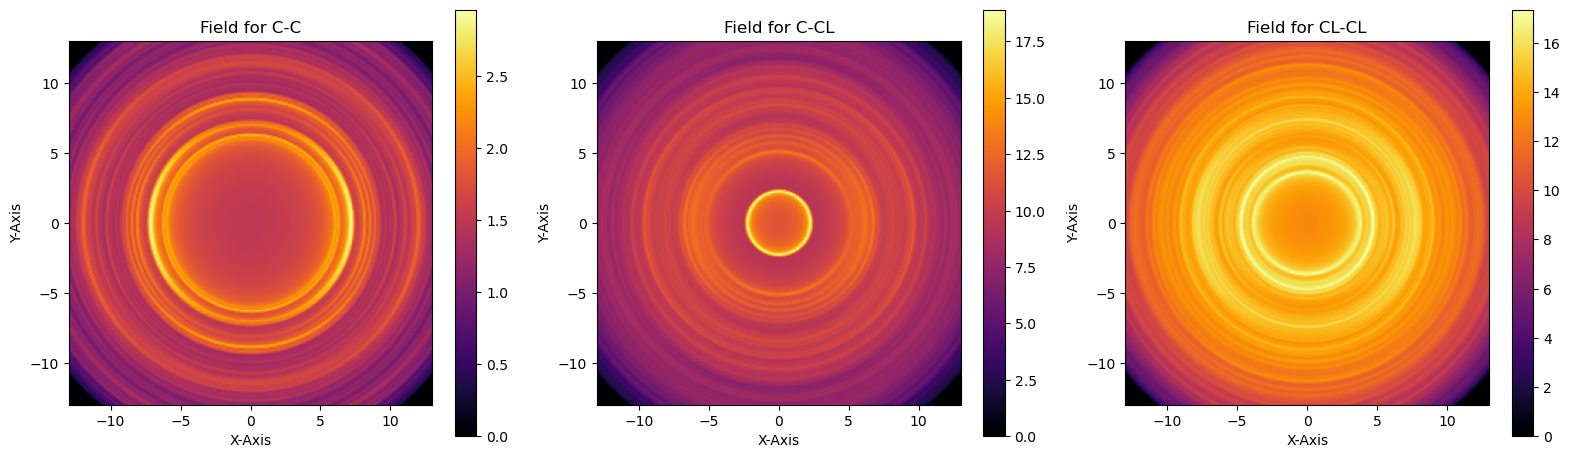

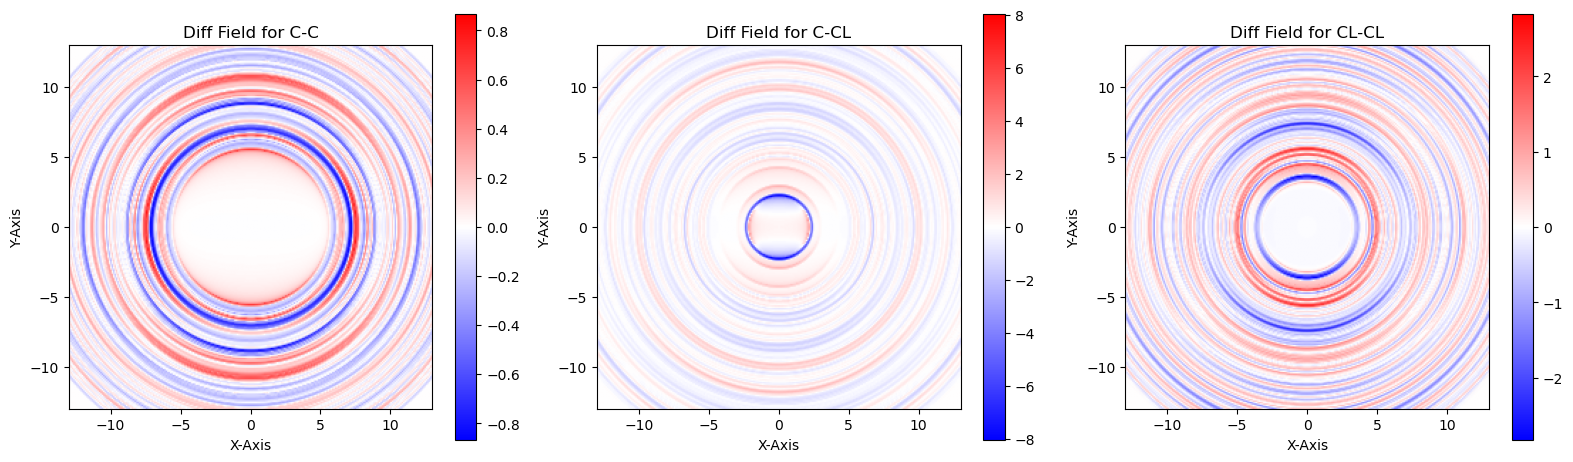

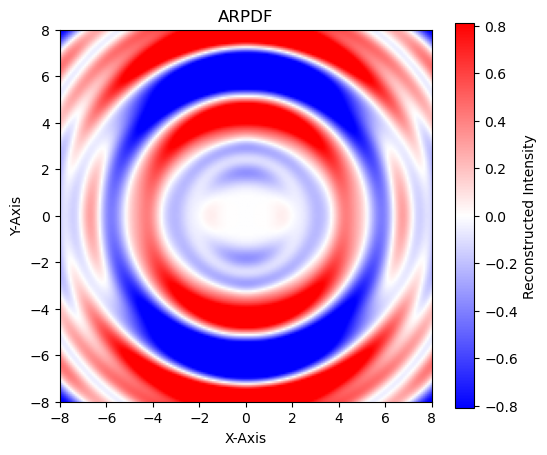

In [4]:
ARPDF_ref = compute_ARPDF(u1, u2, cutoff=13.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=True)

Molecule 519: Similarity = 0.9738542371223831
Polar axis: [0.8569286  0.47545877 0.19902875]
Modified atoms: [515, 519, 516, 517, 518]


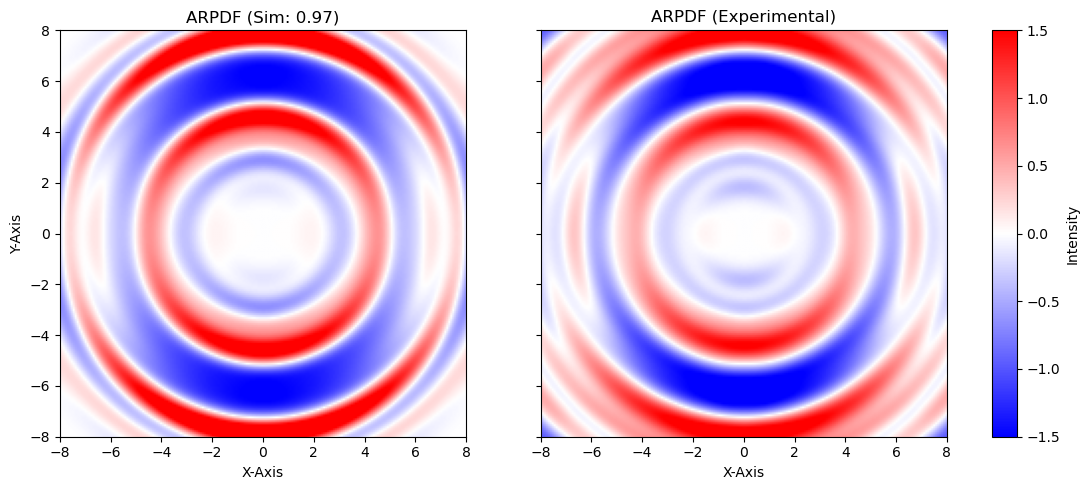

In [5]:
workflow_demo(X, Y, ARPDF_ref, filter_fourier, exp_name="exp1", metric="circle", weight_cutoff=8.0)

In [6]:
u0 = mda.Universe('data/CCl4/CCl4.gro')
dir_name = "exp1"
device = torch.device('cuda')
ARPDF_optimizer = ARPDFOptimizer(
    X, Y, ARPDF_ref, Counter(u0.atoms.types), filter_fourier, cutoff=10.0, weight_cutoff=8.0,
    lr=0.01, gamma=0.995, f_lb=-0.9, s=0.0, beta=0.0, epochs=500, device=device
)
ARPDF_optimizer.set_system(cur_dir=f'tmp/{dir_name}')

lr: 0.009950
Epoch 0, Loss: -0.974979, CosSim: 0.836374
lr: 0.009704
Epoch 5, Loss: -0.983811, CosSim: 0.853858
lr: 0.009464
Epoch 10, Loss: -0.986255, CosSim: 0.855333
lr: 0.009229
Epoch 15, Loss: -0.990651, CosSim: 0.842368
lr: 0.009001
Epoch 20, Loss: -0.991570, CosSim: 0.856605
lr: 0.008778
Epoch 25, Loss: -0.992822, CosSim: 0.845048
lr: 0.008561
Epoch 30, Loss: -0.993971, CosSim: 0.833441
lr: 0.008349
Epoch 35, Loss: -0.994593, CosSim: 0.856180
lr: 0.008142
Epoch 40, Loss: -0.995441, CosSim: 0.841992
lr: 0.007941
Epoch 45, Loss: -0.995843, CosSim: 0.842258
lr: 0.007744
Epoch 50, Loss: -0.996213, CosSim: 0.842051
lr: 0.007553
Epoch 55, Loss: -0.996492, CosSim: 0.799824
lr: 0.007366
Epoch 60, Loss: -0.996478, CosSim: 0.821806
lr: 0.007183
Epoch 65, Loss: -0.996704, CosSim: 0.822646
lr: 0.007005
Epoch 70, Loss: -0.996720, CosSim: 0.824065
lr: 0.006832
Epoch 75, Loss: -0.996807, CosSim: 0.850732
lr: 0.006663
Epoch 80, Loss: -0.996849, CosSim: 0.852187
lr: 0.006498
Epoch 85, Loss: -0.9

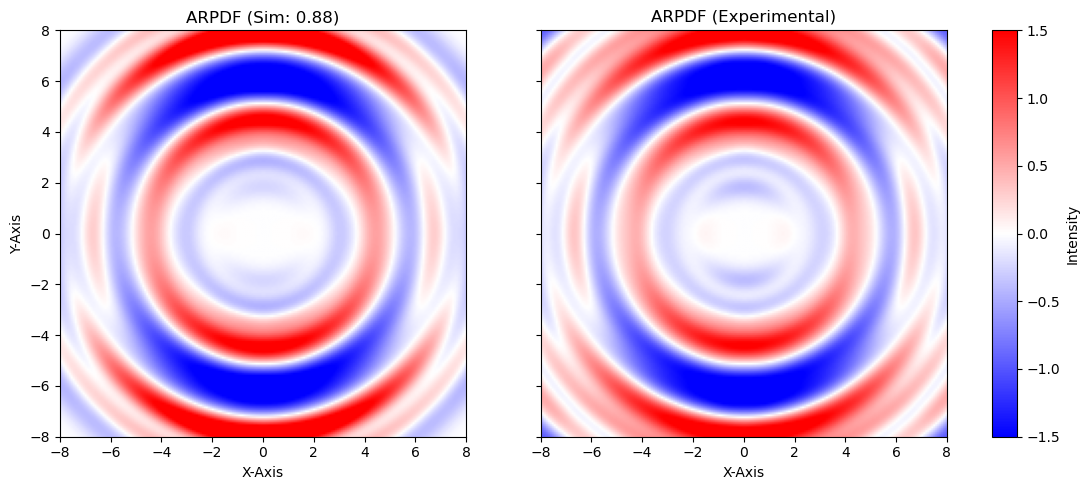

In [7]:
ARPDF_optimizer.optimize()

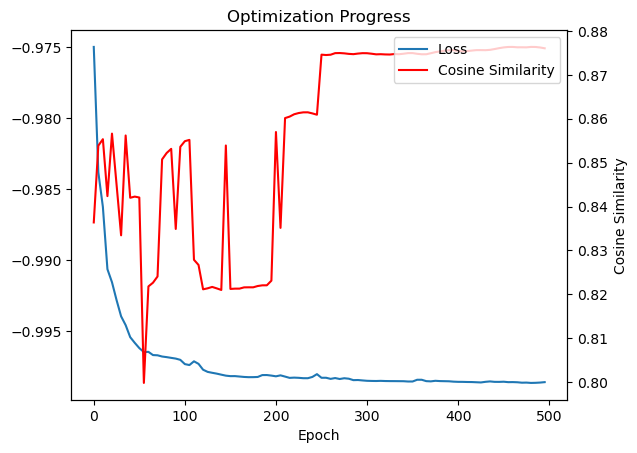

In [8]:
df = pd.read_csv(f"tmp/{dir_name}/log.txt")
epochs = df['epoch'].values
loss = df['loss'].values
cos_sim = df['cos_sim'].values
line1, = plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epoch')
plt.twinx()
line2, = plt.plot(epochs, cos_sim, label='Cosine Similarity', color='red')
plt.ylabel('Cosine Similarity')
plt.legend([line1, line2], ['Loss', 'Cosine Similarity'], loc='upper right')
plt.title('Optimization Progress')
plt.show()

In [9]:
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
polar_axis = np.array(polar_axis)
polar_axis /= np.linalg.norm(polar_axis)
# u2 = mda.Universe('tmp/cos_sim/CCl4_best_init.gro')
trajs = np.load(f"tmp/{dir_name}/traj.npy")[::5]

def rotation_matrix(v1, v2):
    u = v1 - v2
    if np.linalg.norm(u) < 1e-8:
        return np.eye(3)
    u /= np.linalg.norm(u)
    return np.eye(3) - 2 * np.outer(u, u)

R = rotation_matrix(polar_axis, np.array([0., 0., 1.]))
center_group = u2.atoms[modified_atoms]
_center = center_group[0].position[None, :]
around_group = u2.select_atoms("around 6.0 group center", center = center_group, periodic=True)
center_group.positions = utils.box_shift(center_group.positions - _center, u2.dimensions) @ R.T
around_group.positions = utils.box_shift(around_group.positions - _center, u2.dimensions) @ R.T
trajs = utils.box_shift(trajs - _center[None, :, :], u2.dimensions) @ R.T
full_trajs = np.zeros((trajs.shape[0], center_group.n_atoms + around_group.n_atoms, 3))
full_trajs[:, :center_group.n_atoms, :] = trajs
full_trajs[:, center_group.n_atoms:, :] = around_group.positions[None, :, :]
u_new = mda.Merge(center_group, around_group)
u_new.load_new(full_trajs[1:], format="memory", dt=1.0)
# print(around_group.positions[:5])
with mda.Writer(f"tmp/{dir_name}/traj.xyz", center_group.n_atoms + around_group.n_atoms) as W:
    for ts in u_new.trajectory:
        W.write(u_new.atoms)